In [1]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [2]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
matplotlib.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from final.feature_extraction.clean_text import *
from final.feature_encoding.one_hot_encoding import one_hot_encode_feature
from final.feature_extraction.extract_text_info import extract_general_row_info, extract_row_word_counts
from final.model_evaluation.classification_model_evaluation import train_classification_model
from final.model_evaluation.visualizations import visualize_model_feature_importances, visualize_2d_cluster_with_legend


In [3]:
df = pd.read_csv("../../data/random_samples/stratified_sampling_data_by_c2_sz50000_1619216601.csv")
df.shape

(50000, 10)

# Encode C2

In [4]:
encode_df, encode_col = one_hot_encode_feature(df, encode_column='c2',drop_first=False)
encode_df.shape

(50000, 72)

In [5]:
encode_df.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,c1,c3,c2_accessories,...,c2_tops,c2_tops & blouses,c2_toy,c2_toys,c2_trading cards,"c2_tv, audio & surveillance",c2_underwear,c2_video games & consoles,c2_women's accessories,c2_women's handbags
0,560358,NWT LuLaRoe Classic T - XL,1,LuLaRoe,29.0,0,"New with tags LuLaRoe Classic T No rips, stain...",women,t-shirts,0,...,0,1,0,0,0,0,0,0,0,0
1,1104862,NIB - Black&Decker - 2Pack Vacuums,1,Black & Decker,25.0,0,Featuring Lithium Power Strong Cordless Handhe...,home,vacuums & floor care,0,...,0,0,0,0,0,0,0,0,0,0
2,908728,NEW VS pullover,2,Victoria's Secret,26.0,0,NWOT. Victoria's Secret ultimate half zip up p...,women,other,0,...,0,0,0,0,0,0,0,0,0,0
3,715016,Pier One Beaded Tea Light Holder Bundle,3,Pier One,8.0,0,Bundle of 2 pair beaded tea light candle holde...,home,candles & holders,0,...,0,0,0,0,0,0,0,0,0,0
4,187279,Lace up skirt,2,FOREVER 21,19.0,0,The color is kinda maroonish and it's a soft m...,women,mini,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
encode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 72 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   train_id                      50000 non-null  int64  
 1   name                          50000 non-null  object 
 2   item_condition_id             50000 non-null  int64  
 3   brand_name                    50000 non-null  object 
 4   price                         50000 non-null  float64
 5   shipping                      50000 non-null  int64  
 6   item_description              50000 non-null  object 
 7   c1                            50000 non-null  object 
 8   c3                            50000 non-null  object 
 9   c2_accessories                50000 non-null  uint8  
 10  c2_apparel                    50000 non-null  uint8  
 11  c2_athletic apparel           50000 non-null  uint8  
 12  c2_bags and purses            50000 non-null  uint8  
 13  c

# Extract Item Name Features

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
num_of_processes  = 8
col_name = 'name'
clean_col_name = "clean_%s" % col_name

df = parallelize(encode_df, partial(extract_counts, col_name=col_name, prefix="bef"), num_of_processes)
df = parallelize(encode_df, partial(extract_info, col_name=col_name, stop_words=stop_words), num_of_processes)

progress-bar: 100%|██████████| 6250/6250 [01:48<00:00, 57.82it/s]


# Split Train Test

In [8]:
X = df.select_dtypes(include=['int64']).drop(columns=list(encode_col)+['train_id'])
x_col = X.columns
X['name'] = df['name']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item_condition_id  50000 non-null  int64 
 1   shipping           50000 non-null  int64 
 2   upper_word_count   50000 non-null  int64 
 3   upper_char_count   50000 non-null  int64 
 4   stopword_count     50000 non-null  int64 
 5   punctuation_count  50000 non-null  int64 
 6   number_count       50000 non-null  int64 
 7   name               50000 non-null  object
dtypes: int64(7), object(1)
memory usage: 3.1+ MB


In [9]:
y = encode_df[encode_col]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   c2_accessories                50000 non-null  uint8
 1   c2_apparel                    50000 non-null  uint8
 2   c2_athletic apparel           50000 non-null  uint8
 3   c2_bags and purses            50000 non-null  uint8
 4   c2_bath & body                50000 non-null  uint8
 5   c2_bedding                    50000 non-null  uint8
 6   c2_boys (4+)                  50000 non-null  uint8
 7   c2_boys 0-24 mos              50000 non-null  uint8
 8   c2_boys 2t-5t                 50000 non-null  uint8
 9   c2_cameras & photography      50000 non-null  uint8
 10  c2_cell phones & accessories  50000 non-null  uint8
 11  c2_clothing                   50000 non-null  uint8
 12  c2_coats & jackets            50000 non-null  uint8
 13  c2_collectibles               5

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, 
                                                    test_size=0.30, random_state=42, stratify = y)

# Vectorization of Item Name

In [11]:
num_features = 20
tv = TfidfVectorizer(max_features=num_features)
train_name_feature = tv.fit_transform(X_train.name.to_list())

train_name_feature.toarray().shape

(35000, 20)

In [12]:
X_train = np.concatenate((train_name_feature.toarray(), X_train[x_col].values),axis=1)
X_test = np.concatenate((tv.transform(X_test.name.to_list()).toarray(), X_test[x_col].values),axis=1)

In [13]:
names = tv.get_feature_names()
names

['and',
 'baby',
 'black',
 'bundle',
 'dress',
 'for',
 'free',
 'lularoe',
 'men',
 'new',
 'nike',
 'nwt',
 'pink',
 'secret',
 'set',
 'shirt',
 'shorts',
 'size',
 'victoria',
 'vs']

In [14]:
x_tf_names = ['tf%02d_%s'%(i,names[i-1]) for i in range(1, num_features+1)]
x_tf_names += list(x_col)

# Classification - Random Forest

In [15]:
rf_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(RandomForestClassifier(n_estimators=50), 
                                                              X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.4027428571428571

Top 5 class with highest train accuracy
c2_shorts            - 0.85432
c2_underwear         - 0.75986
c2_dresses           - 0.74731
c2_apparel           - 0.69300
c2_tops              - 0.64209

Top 5 class with lowest train accuracy
c2_home décor        - 0.22621
c2_jewelry           - 0.23201
c2_tv, audio & surveillance - 0.24101
c2_toys              - 0.24101
c2_accessories       - 0.26118
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.11966666666666667

Top 5 class with highest test accuracy
c2_shorts            - 0.63598
c2_dresses           - 0.51883
c2_kitchen & dining  - 0.35714
c2_tops              - 0.31513
c2_apparel           - 0.30962

Top 5 class with lowest test accuracy
c2_toys              - 0.00840
c2_women's accessories - 0.01681
c2_men's accessories - 0.02510
c2_jewelry           - 0.02929
c2_tv, audio & surveillance - 0.03347


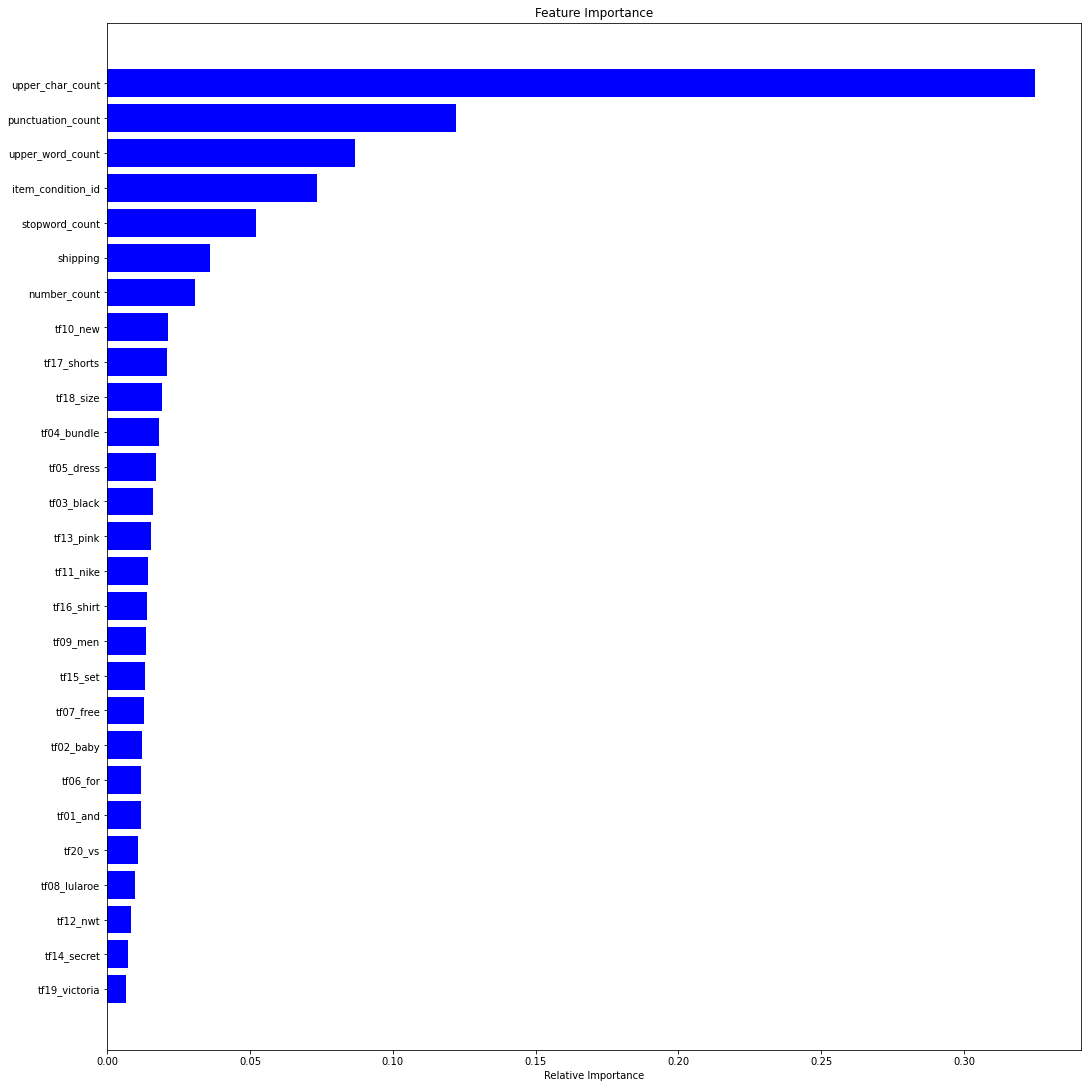

In [16]:
feature_importances = visualize_model_feature_importances(rf_model, x_tf_names, title = "Feature Importance")

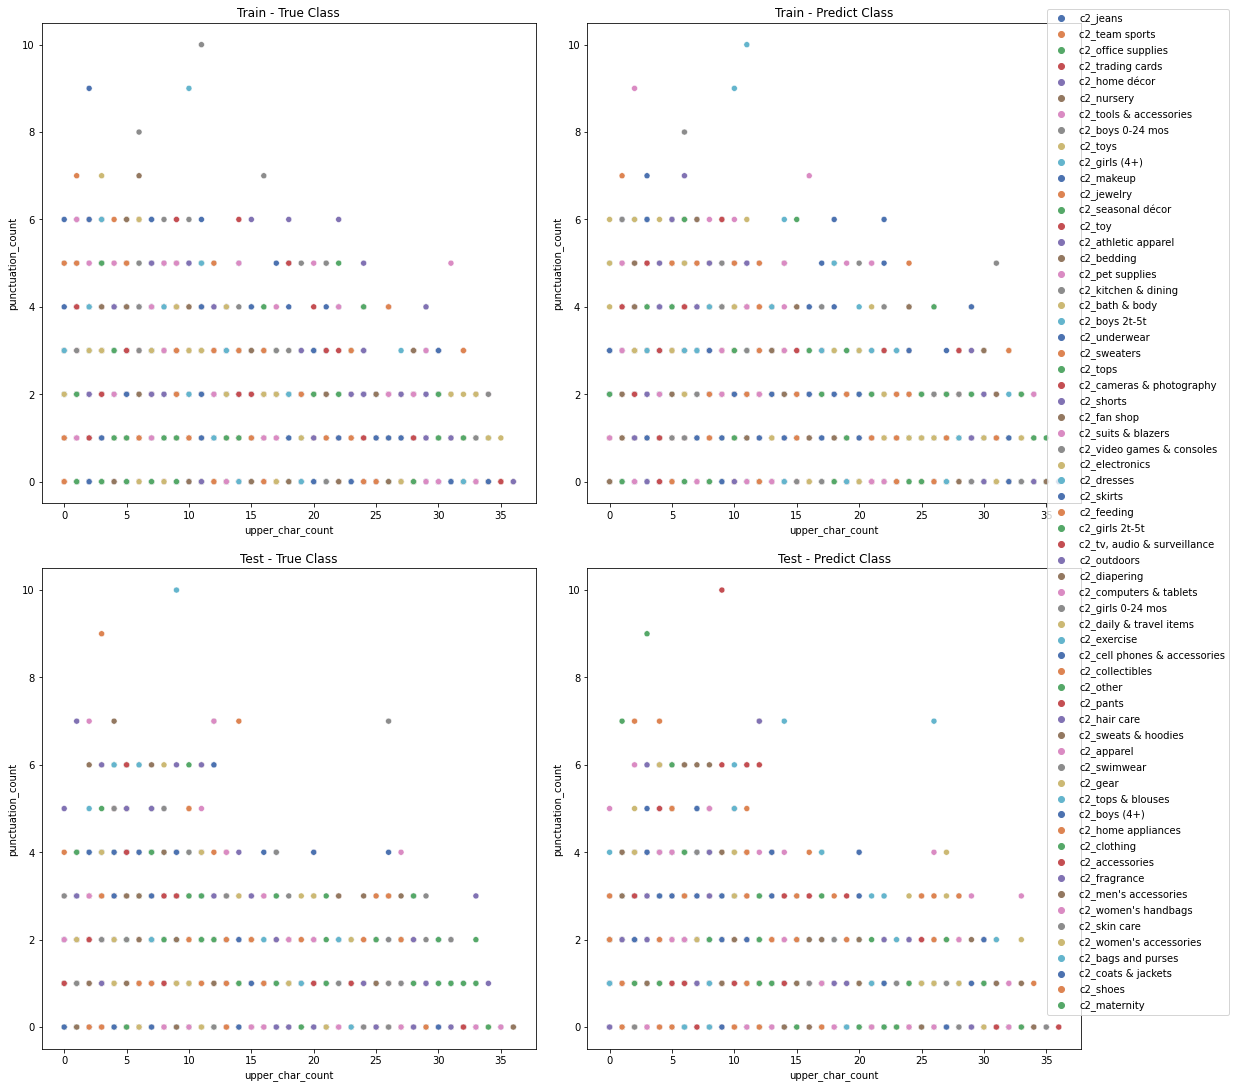

In [17]:
visualize_2d_cluster_with_legend('c2', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred)

# Classification - Logistic Regression

In [18]:
lr_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(LogisticRegression(max_iter=500), 
                                                             X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.1398

Top 5 class with highest train accuracy
c2_shorts            - 0.81115
c2_dresses           - 0.61111
c2_trading cards     - 0.58497
c2_underwear         - 0.51613
c2_kitchen & dining  - 0.51259

Top 5 class with lowest train accuracy
c2_toys              - 0.00000
c2_women's accessories - 0.00180
c2_tv, audio & surveillance - 0.00360
c2_skin care         - 0.00537
c2_collectibles      - 0.00539
--------------------------------------------------
--------------------------------------------------
Test Accuracy: 0.13353333333333334

Top 5 class with highest test accuracy
c2_shorts            - 0.81172
c2_dresses           - 0.66527
c2_trading cards     - 0.53975
c2_kitchen & dining  - 0.51261
c2_tops              - 0.44118

Top 5 class with lowest test accuracy
c2_toys              - 0.00000
c2_women's accessories - 0.00000
c2_skin care         - 0.00418
c2_other             - 0.00418
c2_exercise          - 0.00418


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


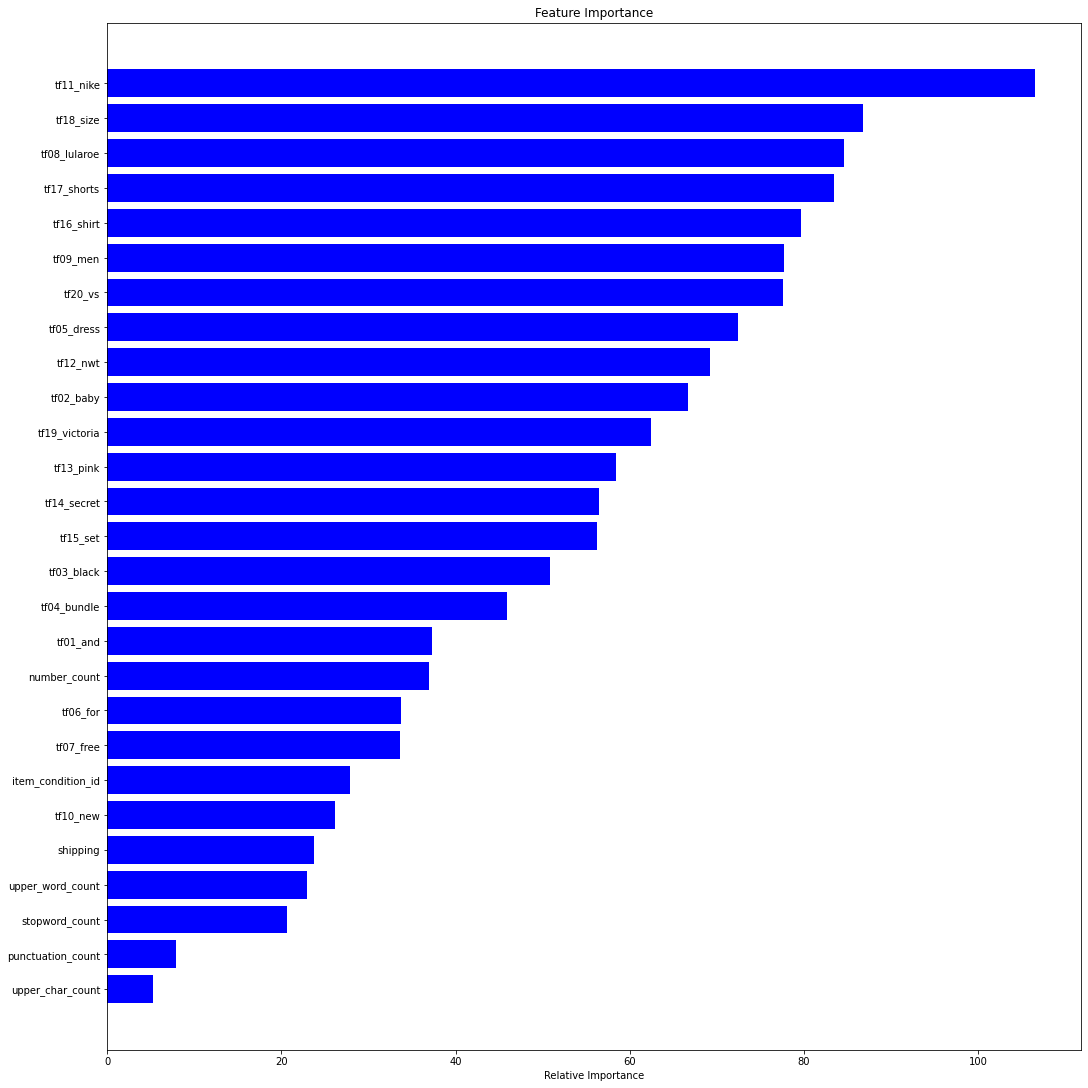

In [20]:
feature_importances = visualize_model_feature_importances(lr_model, x_tf_names, title = "Feature Importance")

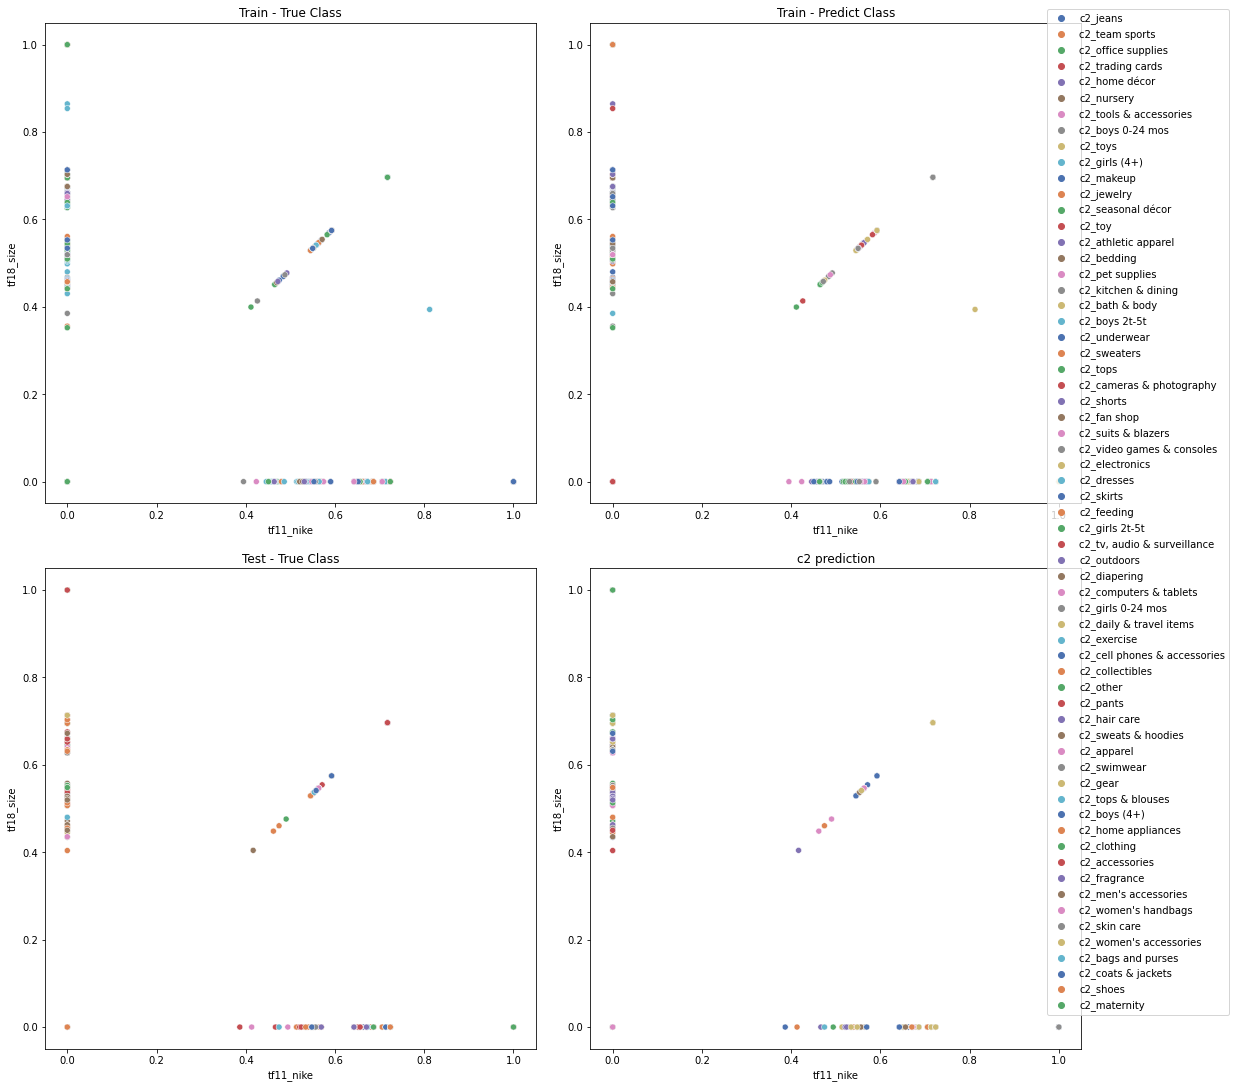

In [21]:
visualize_2d_cluster_with_legend('c2', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred,
                                legend = True, title = "c2 prediction")